In [ ]:
!pip install pandas scikit-learn matplotlib seaborn mlflow openpyxl

     -------------------------------------- 250.9/250.9 kB 1.4 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
from mlflow.tracking import MlflowClient


In [5]:
!pip install xlrd

     -------------------------------------- 96.5/96.5 kB 918.0 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# Load UCI dataset
df = pd.read_excel("default of credit card clients.xls", header=1)

# Rename target column
df.rename(columns={"default payment next month": "default"}, inplace=True)

# Drop ID column
df.drop(columns=["ID"], inplace=True)

df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
X = df.drop("default", axis=1)
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Predictions and probabilities
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)


Accuracy: 0.809
ROC AUC: 0.7632785685296846


2025/04/08 08:47:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'pd_model_real_v1' already exists. Creating a new version of this model...
Created version '2' of model 'pd_model_real_v1'.


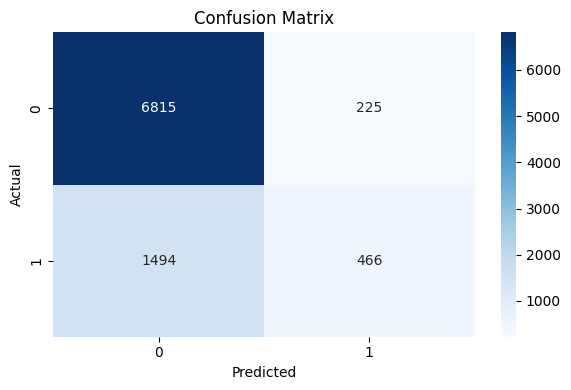

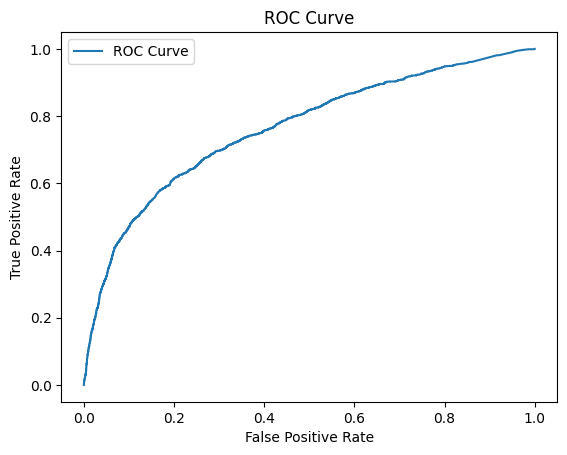

In [ ]:
mlflow.set_experiment("PD_RealData_Experiment")

with mlflow.start_run():
    # Log parameters
    mlflow.log_param("model_type", "RandomForest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 3)

    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("conf_matrix_real.png")
    mlflow.log_artifact("conf_matrix_real.png")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.savefig("roc_curve_real.png")
    mlflow.log_artifact("roc_curve_real.png")

    # Log model and register it
    mlflow.sklearn.log_model(model, "model", registered_model_name="pd_model_real_v1")


In [ ]:
from mlflow.models.signature import infer_signature
import os
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score

# Set experiment just once
mlflow.set_experiment("PD_RealData_Experiment")

#Step 1: Log the dataset once
os.makedirs("logged_data", exist_ok=True)
X_train.to_csv("logged_data/train_data.csv", index=False)
X_test.to_csv("logged_data/test_data.csv", index=False)
y_train.to_csv("logged_data/y_train.csv", index=False)
y_test.to_csv("logged_data/y_test.csv", index=False)

with mlflow.start_run(run_name="Dataset Logging"):
    mlflow.log_artifact("logged_data/train_data.csv", artifact_path="dataset")
    mlflow.log_artifact("logged_data/test_data.csv", artifact_path="dataset")
    mlflow.log_artifact("logged_data/y_train.csv", artifact_path="dataset")
    mlflow.log_artifact("logged_data/y_test.csv", artifact_path="dataset")

#Step 2: Log multiple runs with different max_depth
depths = [3, 5, 7, 10]

for depth in depths:
    model = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    with mlflow.start_run(run_name=f"Depth_{depth}"):
        # Log parameters and metrics
        mlflow.log_param("model_type", model.__class__.__name__)
        mlflow.log_param("max_depth", depth)
        mlflow.log_param("n_estimators", 100)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)

        # Input example and signature
        input_example = X_test.sample(1)
        signature = infer_signature(X_test, model.predict(X_test))

        # Log the model
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            signature=signature,
            input_example=input_example
        )


e:\mlflowMiniProject\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
e:\mlflowMiniProject\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at infer